In [9]:
from roboticstoolbox import *
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from spatialmath import *
import pandas as pd

In [10]:
d = [0.4, 0.135, 0.135, 0.62, 0, 0]
alpha = [pi/2, pi, -pi/2, pi/2, -pi/2, 0]
a = [0.18, 0.6, 0.12, 0, 0, 0]

dh = [RevoluteDH(d=d[i], a=a[i], alpha=alpha[i]) for i in range(0, 6)]
robot = DHRobot(dh, name="robot")

In [11]:
r = 0.5
l = 0.5
points = np.column_stack((
    np.full(6, l),
    r * np.cos(np.radians(144 * np.arange(6) + 90)),
    r * np.sin(np.radians(144 * np.arange(6) + 90))
))

In [12]:
t_sum = 1 # 每段时间
t = 20 # 分割点
t_unit = t_sum / t # 单位时间 
# 梯形轨迹
trajs = [mtraj(trapezoidal, points[i], points[i+1], t) for i in range(5)]
# 五次轨迹
# trajs = [mtraj(quintic, points[i], points[i+1], 20) for i in range(5)]

r = np.concatenate([traj.q for traj in trajs], axis=0)
v = np.concatenate([traj.qd for traj in trajs], axis=0) / t_unit
a = np.concatenate([traj.qdd for traj in trajs], axis=0) / t_unit**2
T = SE3(r) * SE3.OA([0,0,1], [1,0,0])

In [13]:
q0 = [0, pi/2, pi/2, 0, -pi/2, -pi/2]
# Levenberg-Marquardt法
q = np.zeros((100, 6))
q[0] = robot.ikine_LM(T[0], q0).q
for i in range(1, 100):
    q[i] = robot.ikine_LM(T[i], q[i-1]).q
# Newton-Raphson法
""" q = np.zeros((100, 6))
q[0] = robot.ikine_LM(T[0], q0).q
for i in range(1, 100):
     q[i] = robot.ikine_LM(T[i], q[i-1]).q """
# Gauss-Newton法
""" q = np.zeros((100, 6))
q[0] = robot.ikine_LM(T[0], q0).q
for i in range(1, 100):
    q[i] = robot.ikine_LM(T[i], q[i-1]).q """

' q = np.zeros((100, 6))\nq[0] = robot.ikine_LM(T[0], q0).q\nfor i in range(1, 100):\n    q[i] = robot.ikine_LM(T[i], q[i-1]).q '

In [14]:
jacobians = [robot.jacob0(q_) for q_ in q]
v_ = np.hstack([v, np.zeros((t * 5, 3))])
omega = np.squeeze(np.linalg.inv(jacobians) @ v_[:, :, np.newaxis], axis=-1)
alpha = np.append(np.diff(omega, axis=0), np.zeros((1,6)), axis=0)

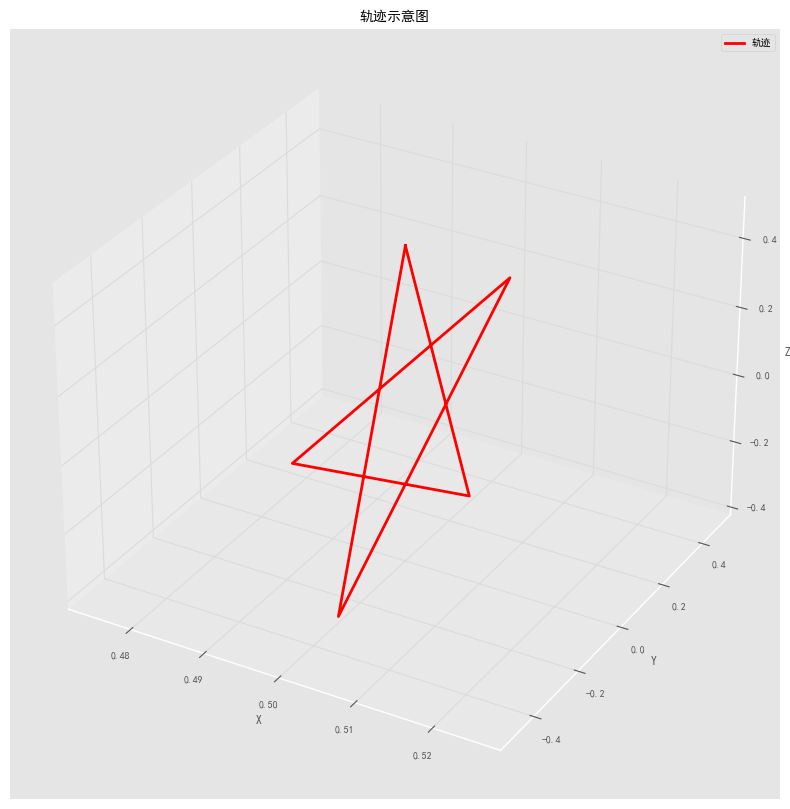

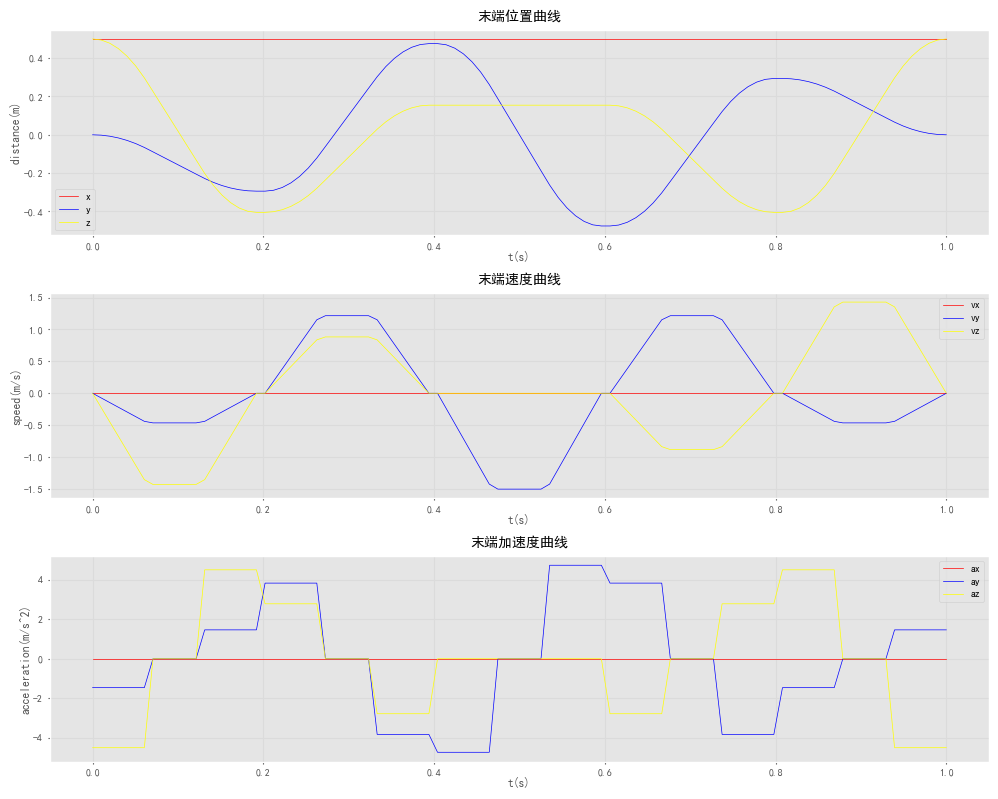

In [15]:
# 绘图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(points[:,0], points[:,1], points[:,2], label='轨迹', color='red', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('轨迹示意图')
ax.legend()
plt.savefig('轨迹示意图.svg')
plt.show()


fig2, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
t_ = np.linspace(0, t_sum, t * 5)
axes[0].plot(t_, r[:,0], color='red', label='x')
axes[0].plot(t_, r[:,1], color='blue', label='y')
axes[0].plot(t_, r[:,2], color='yellow', label='z')
axes[0].set_title('末端位置曲线')
axes[0].set_xlabel('t(s)')
axes[0].set_ylabel('distance(m)')
axes[0].legend()
axes[0].grid(True)
axes[1].plot(t_, v[:,0], color='red', label='vx')
axes[1].plot(t_, v[:,1], color='blue', label='vy')
axes[1].plot(t_, v[:,2], color='yellow', label='vz')
axes[1].set_title('末端速度曲线')
axes[1].set_xlabel('t(s)')
axes[1].set_ylabel('speed(m/s)')
axes[1].legend()
axes[1].grid(True)
axes[2].plot(t_, a[:,0], color='red', label='ax')
axes[2].plot(t_, a[:,1], color='blue', label='ay')
axes[2].plot(t_, a[:,2], color='yellow', label='az')
axes[2].set_title('末端加速度曲线')
axes[2].set_xlabel('t(s)')
axes[2].set_ylabel('acceleration(m/s^2)')
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()
plt.savefig('末端运动曲线.svg')
plt.show()

In [16]:
# 写入csv
time = np.linspace(0, t_sum * 5, t * 5)

combined = np.empty((100, 19))
combined[:, 0] = time
for i in range(6):
    combined[:, 3*i + 1] = np.degrees(q[:, i])
    combined[:, 3*i + 2] = np.degrees(omega[:, i])
    combined[:, 3*i + 3] = np.degrees(alpha[:, i])

df = pd.DataFrame(combined)
df.to_csv('实验一.csv', index=False, header=False, float_format='%.6f')